In [1]:
import numpy as np
import cv2
import pathlib
import os
from scipy.linalg import null_space
import sympy
import time

class Camera:
    
    def __init__(self, val):
        self.img_num = val # カメラ番号（int;コンストラクタ）
        
        f = 8000/3
        cx = 1920/2
        cy = 1080/2
        A = np.zeros((3,3))
        A[0,0] = f
        A[0,2] = cx
        A[1,1] = f
        A[1,2] = cy
        A[2,2] = 1
        
        self.A = A # 内部パラメータ(ndarray)後から更新

    def img_load(self):
        folder_path = "images/six_hole_leaf_image/"
        file_path = os.path.join(folder_path, str(self.img_num) + ".png")
        img = cv2.imread(file_path, 1)# BGRで読み込み
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        self.img = img # 画像(ndarray)
        
    def contour_extraction(self):
        
        color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
        masks = np.ones((self.img.shape[0], self.img.shape[1], 9), dtype=np.uint8)
        
        for i, color in enumerate(color_arr):
            lower = np.clip(color, 0, 255)
            upper = np.clip(color, 0, 255)
            img_mask = cv2.inRange(self.img, lower, upper)
            masks[:,:,i] = img_mask
        
        #self.masks = masks # 色ごとのマスク(nd.array)
        
        contour_list = []

        # 色ごとに輪郭（閉曲線）を抽出
        for i in range(masks.shape[2]):
            contours, hierarchy = cv2.findContours(masks[:,:,i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            contour_list.append(contours)
        self.contour_list = contour_list # 輪郭のリスト(list,ndarray)

        #self.frag_list = contours2fragments(self.contour_list) # フラグメントのリスト(list,ndarray)

    def para_load(self):

        folder_path = pathlib.Path("view_mats/view_mat")
        file_path = os.path.join(folder_path, str(self.img_num)+".csv")
        self.Rt = np.loadtxt(file_path, delimiter="\t")
        self.P = np.dot(self.A, self.Rt[0:3,0:4])
        self.cam_world_cood = -np.dot(self.Rt[0:3,0:3].T, self.Rt[0:3,3])

In [2]:
# 曲線分割
def split_list(contour_length, max_frag_len=100, min_frag_len=40, min_overrap=20):
    
    # 輪郭のフラグメントの位置を指定(最小40 pixl)
    if contour_length > max_frag_len:
        pass
    
    elif contour_length < min_frag_len:
        return None
    
    elif contour_length == min_frag_len:
        return [[0,min_frag_len-1]]
    
    else:
        max_frag_len = contour_length
    
    step0 = np.random.randint(min_frag_len, max_frag_len) # 一つ目のフラグメントの長さ（40から100）
    sep_list = [[0,step0]]
    back = np.random.randint(min_overrap, step0-1) # フラグメントを重ねるために戻す分を決める（最小10 pixl）
    next_start = step0 - back
    
    while True:
        
        # 戻った分(back)より進む
        if back+1 > min_frag_len:
            step = np.random.randint(back+1, max_frag_len)
        else:
            step = np.random.randint(min_frag_len, max_frag_len)

        full_length = next_start + step
        sept = [next_start, full_length]
        sep_list.append(sept)
        back = np.random.randint(min_overrap, step-1)
        next_start = full_length - back

        # 終了判定
        if full_length > contour_length:
            break
    
    # 超過した分戻す（長さはそのまま）
    difference = sep_list[-1][1] - (contour_length-1)
    sep_list[-1][0] -= difference
    sep_list[-1][1] -= difference
    
    return sep_list


def contours_split(contour):
    
    #contour.shape == (N, 2)
    contour_length = contour.shape[0]
    sp_list = split_list(contour_length)
    
    if sp_list == None:
        return None
    
    frag_list = []
    # 位置のリスト通りにスライス
    for sp in sp_list:
        #print(sp)
        frag_list.append(contour[sp[0]:sp[1],:])

    return frag_list


def all_fraged(contours_list):
    
    # 輪郭のリストからフラグメントのリストを得る
    frags_list = []

    #for i in contours_list:
    #temp_list = []
    frags = []
    for j in contours_list:
        temp_frags = contours_split(j.squeeze())
            
        if temp_frags != None:
            frags += temp_frags

    #if frags != []:
    #    frags_list.append(frags)
    
    return frags

def frag_list_fraged(frags_list):# frags_list[色][輪郭][sep][座標]
    img_frag_list = []
    for frag in frags_list:
        color_frag = all_fraged(frag)
        img_frag_list.append(color_frag)
    return img_frag_list

In [3]:
# camera対応
def dim3_distance(vec1, vec2):
    return sum((vec1-vec2)**2)

def camera_correspondence(cam_list):
    vec_list = []
    for i,cam in enumerate(cam_list):
        cam_list[i].para_load()
        vec_list.append(cam_list[i].cam_world_cood)

    pair_list = []
    for i, vec1 in enumerate(vec_list):
        for j, vec2 in enumerate(vec_list):
            if i == j or i > j :
                continue
            elif dim3_distance(vec1,vec2) < 2:
                pair_list.append((i,j))
    
    return pair_list

In [4]:
# epipole取得

def SS_mat(vec3):
    vec3 = np.squeeze(vec3)
    SS_mat = np.zeros((3, 3))
    SS_mat[0,1] = -vec3[2]
    SS_mat[0,2] = vec3[1]
    SS_mat[1,0] = vec3[2]
    SS_mat[1,2] = -vec3[0]
    SS_mat[2,0] = -vec3[1]
    SS_mat[2,1] = vec3[0]
    return SS_mat

def FF_mat(A1, A2, Rt1, Rt2):
    P1 = np.dot(A1, Rt1[0:3,0:4])
    P2 = np.dot(A2, Rt2[0:3,0:4])
    cam_pos1 = -np.dot(Rt1[0:3,0:3].T, Rt1[0:3,3])
    cam_pos1 = np.array([cam_pos1[0], cam_pos1[1], cam_pos1[2], 1])
    epipole2 = np.dot(P2, cam_pos1)
    cam_pos2 = -np.dot(Rt2[0:3,0:3].T, Rt2[0:3,3])
    cam_pos2 = np.array([cam_pos2[0], cam_pos2[1], cam_pos2[2], 1])
    epipole1 = np.dot(P1, cam_pos2)
    return epipole1, epipole2, np.dot(SS_mat(epipole2), np.dot(P2, np.linalg.pinv(P1)))

def contour_disassembly(contour_list):
    con_dis = []
    for i in range(len(contour_list)):
        if contour_list[i] == []:
            continue
        which_dis = np.concatenate(contour_list[i])
        con_dis.append(which_dis)
        
    return np.concatenate(con_dis)

In [5]:
# エピポーラ関係
def epilines_para(frags, F):
    
    lines_list = []
    for color in frags:
        temp_color_list = []
        for frag in color:
            frag_lines = cv2.computeCorrespondEpilines(frag.reshape(-1,1,2), 1,F) # ndarray(フラグメントの座標数,1,3)
            temp_color_list.append(frag_lines)

        lines_list.append(temp_color_list)
    
    return lines_list


def para2line(parameter):
    
    # 一つのパラメータが渡された時を想定
    line_coode = np.zeros((1920,2), dtype=np.int64)
    para = np.squeeze(parameter)# 3次ベクトル
    for x in range(1920):
        y = int((-para[0]*x - para[2])/para[1])
        line_coode[x,0] = x
        line_coode[x,1] = y
    
    return line_coode


def epiline_cal(frag_paras):
    # 全ての色に対するエピポーラ線の帯の計算
    # lines[色][フラグメント][線][座標]
    lines = []
    for color in frag_paras:
        temp_color = []
        
        for frag in color:
            temp_line = []

            for point in frag:
                line = para2line(point)
                temp_line.append(line)

            temp_color.append(temp_line)
        lines.append(temp_color)
        
    return lines


def frags_vs_line(img2_frags, frag_epiline):
    
    # frag_epiline shape(1920, 2)
    surport = np.zeros(len(img2_frags))
    for i in frag_epiline:
        for j, frag in enumerate(img2_frags):
            if i in frag:
                surport[j] += 1
    
    return surport


def pair_frag_idx(img2_frags, frag_epilines):
    surport = np.zeros(len(img2_frags))
    for epi in frag_epilines:
        surport += frags_vs_line(img2_frags, epi)
        
    return surport, np.argmax(surport)


In [6]:
def normalization(vec3):
    return vec3[0]/vec3[2], vec3[1]/vec3[2]

In [7]:
# 再構築
def nom_F(F):
    return (1/sum(sum(F**2))**(1/2))*F

def cover_mat(x1, y1, x2, y2):
    return np.array([[x1**2+x2**2, x2*y2, x2, x1*y1, 0, 0, x1, 0, 0],
                    [x2*y2, x1**2+y2**2, y2, 0, x1*y1, 0, 0, x1, 0],
                    [x2, y2, 1, 0, 0, 0, 0, 0, 0],
                    [x1*y1, 0, 0, y1**2+x2**2, x2*y2, x2, y1, 0, 0],
                    [0, x1*y1, 0, x2*y2, y1**2+y2**2, y2, 0, y1, 0],
                    [0, 0, 0, x2, y2, 1, 0, 0, 0],
                    [x1, 0, 0, y1, 0, 0, 1, 0, 0],
                    [0, x1, 0, 0, y1, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]])

def min_dist(F, pt1, pt2):# pt1が画像2上の点，pt2が画像1上の点
    S0 = 10**10
    x1_ori = pt1[0]
    y1_ori = pt1[1]
    x2_ori = pt2[0]
    y2_ori = pt2[1]
    
    x1 = pt1[0]
    y1 = pt1[1]
    x2 = pt2[0]
    y2 = pt2[1]
    
    x1_tilda = 0
    y1_tilda = 0
    x2_tilda = 0
    y2_tilda = 0
    thita = nom_F(F).flatten()
    it = 0
    while True:
        V_eps = cover_mat(x1, y1, x2, y2)
        eps_ast = np.array([x1*x2 + x2*x1_tilda + x2*x2_tilda,
                           x1*y2 + y2*x1_tilda + x2*y2_tilda,
                           x1 + x1_tilda,
                           y1*x2 + x2*y1_tilda + y1 * x2_tilda,
                           y1* y2 + y2*y1_tilda + y1*y2_tilda,
                           y1 + y1_tilda,
                           x2 + x2_tilda,
                           y2 + y2_tilda,
                           1])
        
        x1_y1_tilda = np.dot(eps_ast, thita) * np.dot(np.array([[thita[0], thita[1], thita[2]], [thita[3], thita[4], thita[5]]]), np.array([x2, y2, 1])) / np.dot(thita, np.dot(V_eps, thita))
        x2_y2_tilda = np.dot(eps_ast, thita) * np.dot(np.array([[thita[0], thita[3], thita[6]], [thita[1], thita[4], thita[7]]]), np.array([x1, y1, 1])) / np.dot(thita, np.dot(V_eps, thita))
        
        x1_tilda = x1_y1_tilda[0]
        y1_tilda = x1_y1_tilda[1]
        x2_tilda = x2_y2_tilda[0]
        y2_tilda = x2_y2_tilda[1]
        
        x1 = x1_ori - x1_tilda
        y1 = y1_ori - y1_tilda
        x2 = x2_ori - x2_tilda
        y2 = y2_ori - y2_tilda
        
        S = x1_tilda**2 + y1_tilda**2 + x2_tilda**2 + y2_tilda**2
        
        if abs(S0 - S) < 0.00001:
            break

        elif it == 20:
            break

        else:
            S0 = S
            it += 1

    return np.array((x1, y1)), np.array((x2, y2))

def Ps(P, pt):
    a = P[0,0] - pt[0]*P[2,0]
    b = P[0,1] - pt[0]*P[2,1]
    c = P[0,2] - pt[0]*P[2,2]
    d = P[0,3]
    e = pt[0]*P[2,3]
    f = P[1,0] - pt[1]*P[2,0]
    g = P[1,1] - pt[1]*P[2,1]
    h = P[1,2] - pt[1]*P[2,2]
    i = P[1,3]
    j = pt[1]*P[2,3]
    return a, b, c, d, e, f, g, h, i, j

def tri(P1, P2, pt1, pt2):
    #x = sympy.Symbol('x')
    #y = sympy.Symbol('y')
    #z = sympy.Symbol('z')
    a1, b1, c1, d1, e1, f1, g1, h1, i1, j1 = Ps(P1, pt1)
    a2, b2, c2, d2, e2, f2, g2, h2, i2, j2 = Ps(P2, pt2)
    T = np.array([[a1, b1, c1],
                 [f1, g1, h1],
                 [a2, b2, c2],
                 [f2, g2, h2]])
    p = np.array([[d1-e1],
                 [i1-j1],
                 [d2-e2],
                 [i2-j2]])
    T_inv = np.linalg.pinv(T)
    result_pt = np.dot(T_inv, -p)
    return result_pt

    #expr1 = a1*x + b1*y + c1*z + d1 - e1
    #expr2 = f1*x + g1*y + h1*z + i1 - j1
    #expr3 = a2*x + b2*y + c2*z + d2 - e2
    #expr4 = f2*x + g2*y + h2*z + i2 - j2
    #print(expr1.subs(sympy.solve([expr2, expr3, expr4])))
    #result = sympy.solve([expr2, expr3, expr4])
    
    #return np.array([result[x], result[y], result[z]])

pt1 = [1920-741,758] # 0
pt2 = [1920-858,834] # 2
F = cam_pairs_F[(0,2)] #0to2
pt2, pt1 = min_dist(F, pt2, pt1)
print(pt1,pt2)

pt1 = np.array([pt1[0],pt1[1],1]) # 0
pt2 = np.array([pt2[0],pt2[1],1]) # 2

np.dot(np.dot(pt2, F),pt1)

tri(cam_list[0].P, cam_list[2].P, pt1, pt2)

In [8]:
import matplotlib.pyplot as plt

In [9]:
cam_list = [Camera(i) for i in range(48)]
for i in range(len(cam_list)):
    cam_list[i].img_load()
    cam_list[i].contour_extraction()
    cam_list[i].para_load()
#cam_pairs = camera_correspondence(cam_list)

In [10]:
# エピポール取得
cam_pairs = camera_correspondence(cam_list)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F

In [11]:
#エピポールと輪郭上の点を結んだ直線と，x軸のなす角
def gene(angles):
    # 正規化
    B = list(map(lambda y:y-min(angles),angles))
    return list(map(lambda y: (y-min(B))/(max(B)-min(B)), B))

def epipole_angle(img_num, epipole_dict):
    cam = cam_list[img_num]
    cam.img_load()
    cam.contour_extraction()
    angle_list = []
    
    for epi in epipole_dict[img_num]:
        epi_angle_list = []
        epi_x = epi[0]
        epi_y = epi[1]
        for color in cam.contour_list:
            color_angle_list = []
            for contour in color:
                contour_angle_list= []
                for cood in contour:
                    x = cood[0][0]
                    y = cood[0][1]
                    tilt = (y-epi_y)/(x-epi_x)
                    angle = np.arctan(tilt)
                    contour_angle_list.append(angle)
                contour_angle_list = gene(contour_angle_list)
                color_angle_list.append(contour_angle_list)
            epi_angle_list.append(color_angle_list)
        angle_list.append(epi_angle_list)
    return angle_list
    
def expand(idx_l, list_length):
    del_list = []
    for i in idx_l:
        if np.isnan(i):
            continue
        if i-2 < 0:
            del_list.append(list_length + i-2)
        else:
            del_list.append(i-2)
        
        if i-1 < 0:
            del_list.append(list_length + i-1)
        else:
            del_list.append(i-1)
        
        del_list.append(i)
        
        if i+1 > list_length-1:
            del_list.append(i+1-list_length)
        else:
            del_list.append(i+1)
        if i+2 > list_length-1:
            del_list.append(i+2-list_length)
        else:
            del_list.append(i+2)
    return sorted(list(set(del_list)))

def differential(angles):
    # エピポーラ線に平行な接線をもつ点(前後方微分の正負を比べたほうが良い)
    del_idx = []
    for i in range(len(angles)):
        if np.isnan(angles[i]):
            continue
        if i == len(angles)-1:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[0]-angles[i]): #or abs(angles[0]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
        else:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[i+1]-angles[i]):# or abs(angles[i+1]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
    #del_idx = expand(del_idx, len(angles))
    
    return del_idx

def marge_del(epi_del_list):
    im_del_list = []
    for i, col in enumerate(epi_del_list[0]):
        color_list = []
        for j, con in enumerate(col):
            color_list.append(list(set(epi_del_list[0][i][j] + epi_del_list[1][i][j])))
        im_del_list.append(color_list)
    return im_del_list

def all_D(angles_list):
    # 画像1枚に対して削除リストを作成
    all_del_list = []
    for epi in angles_list:
        epi_del_list = []
        for color in epi:
            color_del_list = []
            for contour in color:
                #if len(contour)<40:
                #    continue
                del_idx = differential(contour)
                color_del_list.append(del_idx)
            epi_del_list.append(color_del_list)
        all_del_list.append(epi_del_list)
    all_del_list = marge_del(all_del_list)
    return all_del_list

In [12]:
# エピポーラ線との接線で分割
def separate(contour, del_idx):
    # 一つの輪郭に対し削除リストから削除
    start = 0
    newArray = []
    for d in del_idx:
        if contour[start:d] != []:
            if contour[start:d].size != 0:
                newArray.append(contour[start:d])
        start = d+1

    if contour[start:].size != 0:
        newArray.append(contour[start:])
    return newArray

def all_sep(con_list, del_list):
    n_list = []
    for col, del_col in zip(con_list, del_list):
        n_col_list = []
        for con, del_con in zip(col, del_col) :
            n_con = separate(con, del_con)
            for frag in n_con:
                n_col_list.append(frag)
        n_list.append(n_col_list)
    return n_list

In [13]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict))# im_del_list[color][contour][del_idx]
    #newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(cam_list[i].contour_list)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [14]:
cnum = 4
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)

for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        new_img[curve[:,1],curve[:,0]]=True

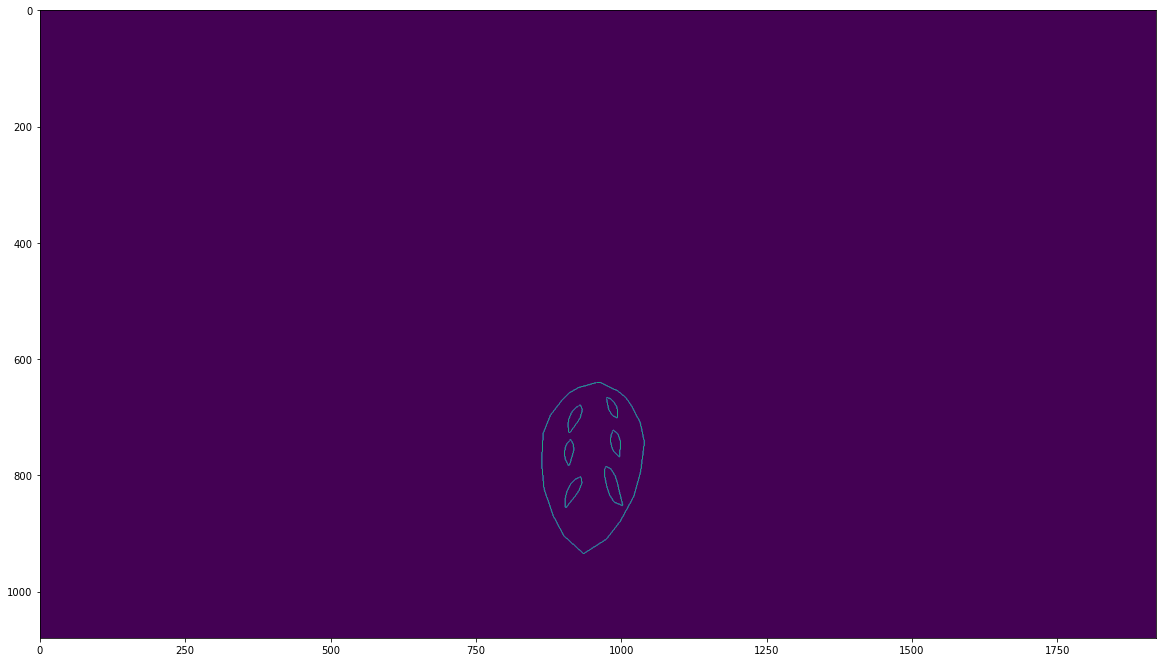

In [15]:
%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(new_img)

In [16]:
# 衝突判定
def para2cood_S(para_list):
    return np.array([[0, -c/b] for a,b,c in para_list])

def para2cood_F(para_list):
    return np.array([[1920, -(1920*a+c)/b] for a,b,c in para_list])

def all_pa2co(para_list):
    epi_cood_S = []
    epi_cood_F = []
    for color in para_list:
        color_list_S = []
        color_list_F = []
        for frag in color:
            S_cood = para2cood_S(frag.squeeze())
            F_cood = para2cood_F(frag.squeeze())
            color_list_S.append(S_cood)
            color_list_F.append(F_cood)
        epi_cood_S.append(color_list_S)
        epi_cood_F.append(color_list_F)
    return epi_cood_S, epi_cood_F # epi_cood[color][frag]

def get_frag_cood(frag_list):
    cood_S = []
    cood_F = []
    for color in frag_list:
        col_S = np.array([frag[0] for frag in color])
        col_F = np.array([frag[-1] for frag in color])
        cood_S.append(col_S)
        cood_F.append(col_F)
    return cood_S, cood_F # cood_S[color][frag]

def coll_t1_t2(epi_cood_S, epi_cood_F, cood_S, cood_F):
    epi_cood_S_bro = np.repeat(epi_cood_S,len(cood_S),axis=0).reshape((epi_cood_S.shape[0],len(cood_S),epi_cood_S.shape[1]))
    epi_cood_F_bro = np.repeat(epi_cood_F,len(cood_S),axis=0).reshape((epi_cood_F.shape[0],len(cood_S),epi_cood_F.shape[1]))
    v = cood_S - epi_cood_S_bro
    v2 = cood_F - cood_S
    v1 = epi_cood_F_bro - epi_cood_S_bro
    t1 = np.cross(v, v2)/np.cross(v1, v2)
    t2 = np.cross(v, v1)/np.cross(v1, v2)
    return t1, t2

def coll_det(t1, t2):
    t1_t = np.array((t1 <= 1) & (t1 > 0),dtype=np.int16)
    t2_t = np.array((t2 <= 1) & (t2 > 0),dtype=np.int16)
    count_c = np.array(t1_t + t2_t == 2, dtype=np.int64)
    #surport_idx = np.argmax(np.sum(count_c,axis=0))
    count_c = np.sum(count_c,axis=0)
    sorted_count_c = np.argsort(count_c)
    count_c = np.where(sorted_count_c > np.max(sorted_count_c)-10)[0]
    return count_c#surport_idx

def make_piar_list(epi_cood_S, epi_cood_F, cood_S, cood_F):
    img_list=[]
    for epi_S_col, epi_F_col, S_col, F_col in zip(epi_cood_S, epi_cood_F, cood_S, cood_F):
        color_list = []
        if len(epi_S_col) == 0 or len(S_col) == 0:
            img_list.append(color_list)
            continue
        for epi_S_frag, epi_F_frag in zip(epi_S_col, epi_F_col):
            t1, t2 = coll_t1_t2(epi_S_frag, epi_F_frag, S_col, F_col)
            surport_idx = coll_det(t1, t2)
            color_list.append(surport_idx)
        img_list.append(color_list)
    return img_list

In [17]:
def pair_and_key_gen(pair):
    pair_list = {}
    F = cam_pairs_F[pair]
    frags_para12 = epilines_para(cam_list[pair[0]].frag_list, F) # frags_para[色][frag]
    frags_para21 = epilines_para(cam_list[pair[1]].frag_list, F.T)

    cood_S, cood_F = get_frag_cood(cam_list[pair[1]].frag_list)
    epi_cood_S, epi_cood_F = all_pa2co(frags_para12)
    img_list1 = make_piar_list(epi_cood_S, epi_cood_F, cood_S, cood_F)

    cood_S, cood_F = get_frag_cood(cam_list[pair[0]].frag_list)
    epi_cood_S, epi_cood_F = all_pa2co(frags_para21)
    img_list2 = make_piar_list(epi_cood_S, epi_cood_F, cood_S, cood_F)

    pair_list[((pair[0],pair[1]), "F")] = img_list1
    pair_list[((pair[0],pair[1]), "R")] = img_list2
    return pair_list

In [18]:
%%time
import joblib
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(pair_and_key_gen)(i) for i in cam_pairs_F)


Wall time: 28.1 s


In [19]:
pair_list = {}
for i in result:
    pair_list.update(i)

In [20]:
#pair_list[key][color][curve][pair]

In [21]:
# 線と点の衝突判定
def PL_coll(pair, pair_list, cam_list):
    F = cam_pairs_F[pair[0]]
    if pair[1] == "F":
        frags_para = epilines_para(cam_list[pair[0][0]].frag_list, F) # frags_para[色][frag]
        epi_cood_S, epi_cood_F = all_pa2co(frags_para)
        camL_idx = pair[0][1]
    elif pair[1] == "R":
        frags_para = epilines_para(cam_list[pair[0][1]].frag_list, F.T)
        epi_cood_S, epi_cood_F = all_pa2co(frags_para)
        camL_idx = pair[0][0]

    im_list = []
    for pair_col, col_part, epi_S_col, epi_F_col in zip(pair_list[pair], cam_list[camL_idx].frag_list, epi_cood_S, epi_cood_F):
        col_list=[]
        for pair_frag, epi_S_frag, epi_F_frag in zip(pair_col, epi_S_col, epi_F_col):
            f_list = []
            for pair_frag_each in pair_frag:
                pts = col_part[pair_frag_each] # 対応するフラグメント
                v1 = epi_F_frag - epi_S_frag
                v1_n = (v1[:,0]**2+v1[:,1]**2)**(1/2)
                v1_n = np.stack([v1_n, v1_n], axis=1)
                v1 = v1/v1_n

                v1_bro = np.repeat(v1,len(pts),axis=0).reshape((v1.shape[0],len(pts),v1.shape[1]))
                epi_cood_S_bro = np.repeat(epi_S_frag,len(pts),axis=0).reshape((epi_S_frag.shape[0],len(pts),epi_S_frag.shape[1]))

                v2 = pts - epi_cood_S_bro
                v2_n = (v2[:,:,0]**2+v2[:,:,1]**2)**(1/2)
                v2_n = np.stack([v2_n, v2_n], axis=2)
                v2 = v2/v2_n
                con_det = np.cross(v1_bro, v2)
                f_list.append(np.where(np.abs(con_det) <= 0.001))
            col_list.append(f_list)
        im_list.append(col_list)
        
    return im_list

In [22]:
# 点と線の衝突判定
def coll_dict_gen(pair):
    coll_dict = {}
    im_list = PL_coll(pair, pair_list, cam_list)
    coll_dict[pair] = im_list
    return coll_dict

In [23]:
%%time
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(coll_dict_gen)(i) for i in pair_list)


Wall time: 4min 36s


In [24]:
coll_dict = {}
for i in result:
    coll_dict.update(i)

In [25]:
def pt_pair(coll_list):
    pool_i = []
    pool_j = []
    pre_i = None
    pre_j = None
    pt = 1
    for i, j in zip(coll_list[0], coll_list[1]):
        if i in pool_i:
            if pt == 1:
                continue
            elif pt == 0:
                if j not in pool_j:
                    pool_i.pop()
                    pool_j.pop()
                    pool_i.append(i)
                    pool_j.append(j)
                else:
                    continue

        elif i not in pool_i:
            if j in pool_j:
                pt = 0
            else:
                pt = 1
            pool_i.append(i)
            pool_j.append(j)
    return np.array([pool_i, pool_j])

In [26]:
# 点の一対一対応
pair_pt = {}
for i in coll_dict:
    im_list = []
    for col in coll_dict[i]:
        col_list = []
        for frag in col:
            f_list = []
            for each_frag in frag:
                new_pair = pt_pair(each_frag)
                f_list.append(new_pair)
            col_list.append(f_list)
        im_list.append(col_list)
    pair_pt[i] = im_list

In [27]:
def FR_frags(dict_tag):
    if dict_tag[1] == "F":
        part = cam_list[dict_tag[0][0]].frag_list
        counterpart = cam_list[dict_tag[0][1]].frag_list
        return part, counterpart
        
    elif i[1] == "R":
        part = cam_list[dict_tag[0][1]].frag_list
        counterpart = cam_list[dict_tag[0][0]].frag_list
        return part, counterpart

In [28]:
def cv2_circle_array(img, co, size, color, r):
    for i in range(len(co)):
        img = cv2.circle(img, co[i], 10, (0,100,0), -1)
    return img

cnum = 0
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
copy_img = np.copy(cam_list[cnum].img)
for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        if i == 6:
            img = cv2_circle_array(copy_img, curve, 10, (0,0,255), -1)
        #new_img[curve[:,1],curve[:,0]]=True
            break
    break

%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(img)

cnum = 1
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
copy_img = np.copy(cam_list[cnum].img)
for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        if i == 27:
            img = cv2_circle_array(copy_img, curve, 10, (0,0,255), -1)
        #new_img[curve[:,1],curve[:,0]]=True
            break
    break

%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)

plt.imshow(img)#new_img)

In [29]:
# 座標でdictを作る
coordinate_dict = {}
for i in pair_list:
    pair_coordinate = []
    part, counterpart = FR_frags(i)
    for part_col, cpart_col, pair_col, PtPair_col in zip(part, counterpart, pair_list[i], pair_pt[i]):
        col_list = []
        for part_frag, pair, pt_idx in zip(part_col, pair_col, PtPair_col):
            for each_pair, each_pt_idx in zip(pair, pt_idx):
                if each_pt_idx[0].size != 0:
                    col_list.append((np.array([part_frag[each_pt_idx[0]], cpart_col[each_pair][each_pt_idx[1]]])))
        pair_coordinate.append(col_list)
    coordinate_dict[i] = pair_coordinate

In [30]:
def FR_check(dict_tag):
    if dict_tag[1] == "F":
        P1 = cam_list[dict_tag[0][0]].P
        P2 = cam_list[dict_tag[0][1]].P
        F = cam_pairs_F[dict_tag[0]]
        return P1, P2, F
    elif dict_tag[1] == "R":
        P1 = cam_list[dict_tag[0][1]].P
        P2 = cam_list[dict_tag[0][0]].P
        F = cam_pairs_F[dict_tag[0]].T
        return P1, P2, F

In [31]:
def connect_points(pts_list):
    sep_list = []
    root = np.transpose(pts_list[0], (1, 0, 2))
    length = len(root)-1
    sep_list.append(length)
    for i, pt in enumerate(pts_list):
        pt = np.transpose(pt, (1, 0, 2))
        if i == 0:
            continue
        root = np.concatenate([root, pt], 0)
        length += len(pt)
        sep_list.append(length)
    return root, sep_list

def sep_array(tri_pts, sep_list):
    # 一つの輪郭に対し削除リストから削除
    start = 0
    newArray = []
    for d in sep_list:
        if tri_pts[start:d].size != 0:
            newArray.append(tri_pts[start:d])
        start = d

    if tri_pts[start:].size != 0:
        newArray.append(tri_pts[start:])
    return newArray

TDlines = []
for i, j in enumerate(coordinate_dict):
    
    pts = coordinate_dict[j]
    P1_ori, P2_ori, F_ori = FR_check(j)
    #pt, sep_list = connect_points(pts)
    temp_TDlines = []
    for pt in pts:
        pt = np.transpose(pt, (1, 0, 2))
        F = np.broadcast_to(F_ori, (pt.shape[0],3,3))
        P1 = np.broadcast_to(P1_ori, (pt.shape[0],3,4))
        P2 = np.broadcast_to(P2_ori, (pt.shape[0],3,4))
        newcoords= np.array(list(map(min_dist, F, pt[:,1,:], pt[:,0,:])))
        tri_pt = np.array(list(map(tri, P1, P2, newcoords[:,1,:], newcoords[:,0,:])))
        #pts_array = sep_array(tri_pt, sep_list)
        temp_TDlines.append(tri_pt)
    TDlines.append(temp_TDlines)
    print((i+1)/len(coordinate_dict)*100)
    break

In [32]:
TDlines = {}
for i, j in enumerate(coordinate_dict):
    
    pts = coordinate_dict[j]
    P1_ori, P2_ori, F_ori = FR_check(j)
    #pt, sep_list = connect_points(pts)
    temp_TDlines = []
    for pts_col in pts:
        col_list = []
        for pt in pts_col:
            pt = np.transpose(pt, (1, 0, 2))
            F = np.broadcast_to(F_ori, (pt.shape[0],3,3))
            P1 = np.broadcast_to(P1_ori, (pt.shape[0],3,4))
            P2 = np.broadcast_to(P2_ori, (pt.shape[0],3,4))
            newcoords= np.array(list(map(min_dist, F, pt[:,1,:], pt[:,0,:])))
            tri_pt = np.array(list(map(tri, P1, P2, newcoords[:,1,:], newcoords[:,0,:])))
            #pts_array = sep_array(tri_pt, sep_list)
            col_list.append(tri_pt)
        temp_TDlines.append(col_list)
    TDlines[j] = temp_TDlines
    print((i+1)/len(coordinate_dict)*100)


0.3787878787878788
0.7575757575757576
1.1363636363636365
1.5151515151515151
1.893939393939394
2.272727272727273
2.6515151515151514
3.0303030303030303
3.4090909090909087
3.787878787878788
4.166666666666666
4.545454545454546
4.924242424242424
5.303030303030303
5.681818181818182
6.0606060606060606
6.4393939393939394
6.8181818181818175
7.196969696969697
7.575757575757576
7.954545454545454
8.333333333333332
8.712121212121213
9.090909090909092
9.469696969696969
9.848484848484848
10.227272727272728
10.606060606060606
10.984848484848484
11.363636363636363
11.742424242424242
12.121212121212121
12.5
12.878787878787879
13.257575757575758
13.636363636363635
14.015151515151514
14.393939393939394
14.772727272727273
15.151515151515152
15.530303030303031
15.909090909090908
16.28787878787879
16.666666666666664
17.045454545454543
17.424242424242426
17.803030303030305
18.181818181818183
18.560606060606062
18.939393939393938
19.318181818181817
19.696969696969695
20.075757575757574
20.454545454545457
20.83

In [33]:
def excluded_Parray(ex_tag):
    P_dict = {}
    for i, cam in enumerate(cam_list):
        if i in ex_tag:
            continue
        P_dict[i] = cam.P
    return P_dict

def dot_P_frag(P, frag):
    repro_frag = []
    for pt in frag:
        repro_pt = np.dot(P, pt)
        repro_pt = np.array(normalization(repro_pt))
        repro_frag.append(repro_pt)
    return np.array(repro_frag)

In [34]:
reprojection_dict = {}
for tag in TDlines:
    temp_reprojection_dict = {}
    P_dict = excluded_Parray(tag[0])
    for P_tag in P_dict:
        P = P_dict[P_tag]
        P_list = []
        for col in TDlines[tag]:
            col_list = []
            for i, frag in enumerate(col):
                frag = frag.reshape((-1,3))
                frag = np.concatenate([frag, np.ones(len(frag)).reshape((len(frag), 1))],1) # 末尾に1を追加 (X, Y, Z, 1)
                reprojection = dot_P_frag(P, frag)
                col_list.append(reprojection)
            P_list.append(col_list)
        temp_reprojection_dict[P_tag] = P_list
    reprojection_dict[tag] = temp_reprojection_dict

In [35]:
def connect_contour(contour_list):
    con_list = []
    for col in contour_list:
        if len(col) == 0:
            con_list.append(np.empty((1,2)))
            continue
        A = np.concatenate(col).reshape((-1, 2))
        con_list.append(A)
    return con_list

In [36]:
def cal_distance(repro_P, contour_P):
    contour_P = connect_contour(contour_P)
    distance_list = []
    for repro_col, con_col in zip(repro_P, contour_P):
        col_list = []
        for repro_frag in repro_col:
            repro_frag_bro = np.repeat(repro_frag, len(con_col),axis=0).reshape((repro_frag.shape[0], len(con_col), repro_frag.shape[1]))
            distance = (np.sum((con_col - repro_frag_bro)**2,axis=2))**(1/2)
            col_list.append(distance)
        distance_list.append(col_list)
    return distance_list

def distance_check(distance_list):
    dist_check_list = []
    ac_list = []
    for col in distance_list:
        col_list = []
        ac_col_list = []
        for frag in col:
            ac = np.array((np.min(frag,axis=1)) < 5,dtype=np.int64) # 条件:10 pixel以内
            col_list.append(sum(ac)/len(ac))
            ac_col_list.append(ac)
        ac_list.append(ac_col_list)
        dist_check_list.append(np.array(col_list))
    return ac_list, dist_check_list

def P_dict_check(repro_dict_taged):
    P_list = []
    P_ac_list = []
    for P_tag in repro_dict_taged:
        repro_P = repro_dict_taged[P_tag]
        contour_P = cam_list[P_tag].contour_list
        distance_list = cal_distance(repro_P, contour_P)
        ac_list, dist_check_list = distance_check(distance_list)
        P_list.append(dist_check_list)
        P_ac_list.append(ac_list)
    P_check = np.array(P_list)
    return ac_list, P_ac_list, P_check

def P_check_integration(P_check):
    check_list = []
    for col in range(P_check.shape[1]):
        temp_list = []
        for img in P_check[:,col]:
            temp = np.array(img > 0.8,dtype=np.int64)# 曲線中の何割が閾値以内か
            temp_list.append(temp)
        col_check = np.sum(np.array(temp_list),axis=0)
        check_list.append(col_check)
    return check_list

def ac_list_integration(P_ac_list):
    inter_ac = []
    for i, col in enumerate(P_ac_list[0]):
        col_list = []
        for j in range(len(col)):
            temp_array = np.zeros(len(P_ac_list[0][i][j]))
            for img in P_ac_list:
                temp_array += img[i][j]
            col_list.append(temp_array)
        inter_ac.append(col_list)
    return inter_ac
    
def gen_support_dict(reprojection_dict):
    support_dict = {}
    for tag in reprojection_dict:
        repro_dict_taged = reprojection_dict[tag]
        _, P_ac_list, P_check = P_dict_check(repro_dict_taged)
        check_list = P_check_integration(P_check)
        inter_ac = ac_list_integration(P_ac_list)
        support_dict[tag] = (check_list, inter_ac)
    return support_dict

def get_tilt(curve):
    tilt_list = []
    for i in renge(curve):
        if i == 0:
            tilt = (curve[i]-curve[i+1])
            
        elif i == len(curve) - 1:
            tilt = (curve[i-1]-curve[i])
            
        else:
            tilt = (curve[i-1]-curve[i+1])/2
        tilt_list.append(tilt)
    return np.array(tilt_list)

def tilt_comparison(tilt1, tilt2):
    angle1 = np.arctan(tilt1)
    angle2 = np.arctan(tilt2)
    return np.abs(angle1-angle2)

def tilt_filter(curve1, curve2):
    tilt1 = get_tilt(curve1)
    tilt2 = get_tilt(curve2)
    tilt_com_list = tilt_comparison(tilt1, tilt2)
    return tilt_com_list


In [37]:
support_dict = gen_support_dict(reprojection_dict)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [38]:
sup_th = 10# サポート数
curve_fragment = []
for tag in TDlines:
    #if tag[1] == "R":
    #    continue
    lines_list = TDlines[tag]
    support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > 11:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [39]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

<IPython.core.display.Javascript object>


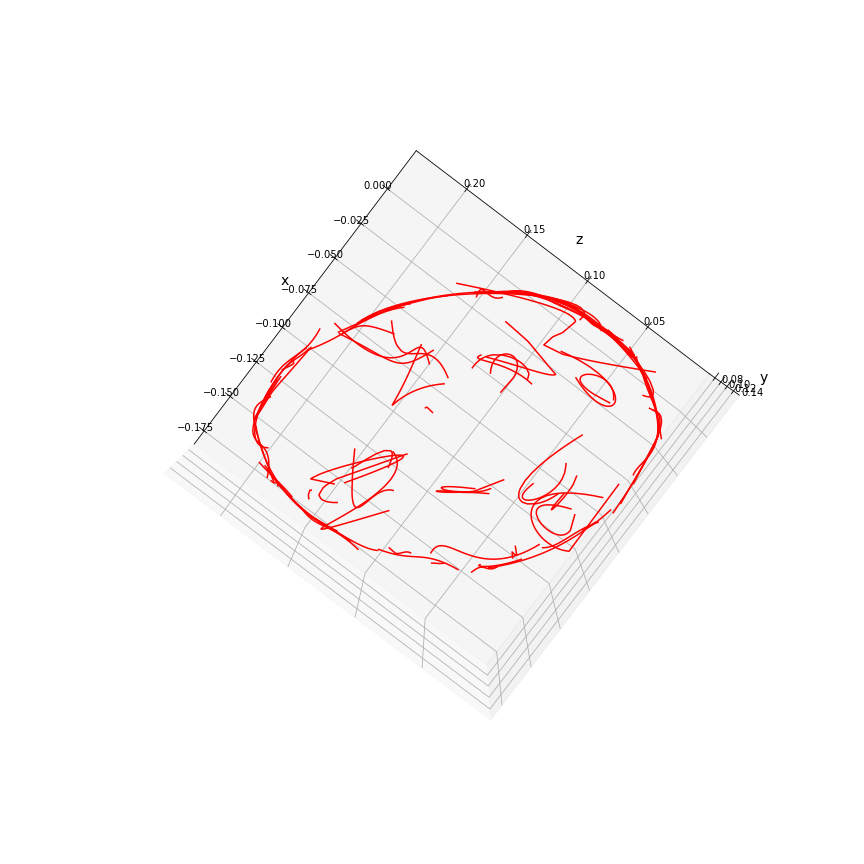

In [46]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size == 0:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 100 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1


        
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [41]:
import itertools

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_curve_fragment)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

o3d.visualization.draw_geometries([pcd])

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    i = 0
    for c_f in curve_fragment:
        for frag in c_f:
            if frag.size == 0:
                continue
            #print(frag)
            
            if i%100 == 0:
                x = frag[:,0]
                y = frag[:,1]
                z = frag[:,2]
                data = [x,y,z]
                try:
                    tck, u= interpolate.splprep(data, k=3)
                except ValueError:
                    pass
                except TypeError:
                    pass
                new = interpolate.splev(u, tck, der=0)

                ax.plot(new[0], new[2], new[1],"-")
                    #ax.plot(x, z, y,"-")
            i += 1

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
# アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

# imagemagickで作成したアニメーションをGIFで書き出す
ani.save("48_rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
#ani.save('48_anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})

In [43]:
import pickle
with open("six_hole_leaf.curves","wb") as f:
    pickle.dump(curve_fragment, f)